In [43]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

(1200, 1080)


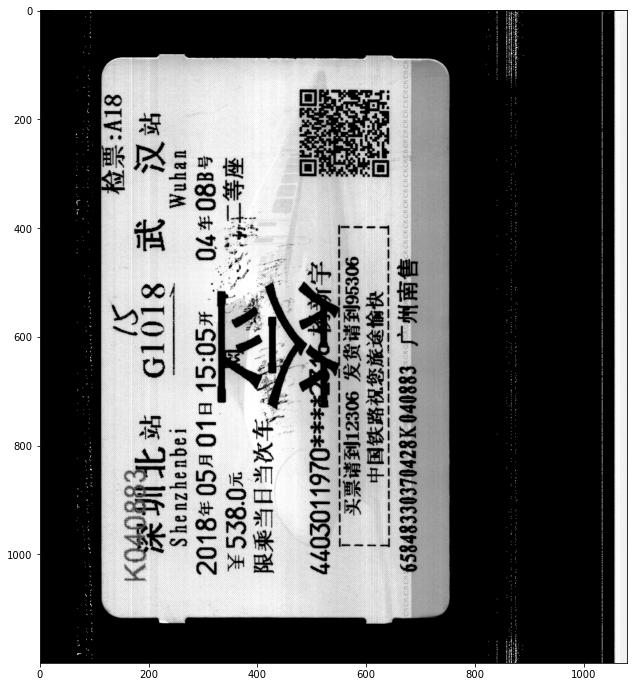

In [44]:
#img = cv2.imread('test_data/2018-5-22-17-55-14.bmp', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('test_data/2018-5-22-18-3-53.bmp', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('test_data/2018-5-22-18-0-54.bmp', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('test_data/2018-5-22-17-56-20.bmp', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.figure(figsize = (12, 12))
plt.imshow(img, cmap = "gray")
plt.show()

# 车票票面检测

## 预处理

107.0


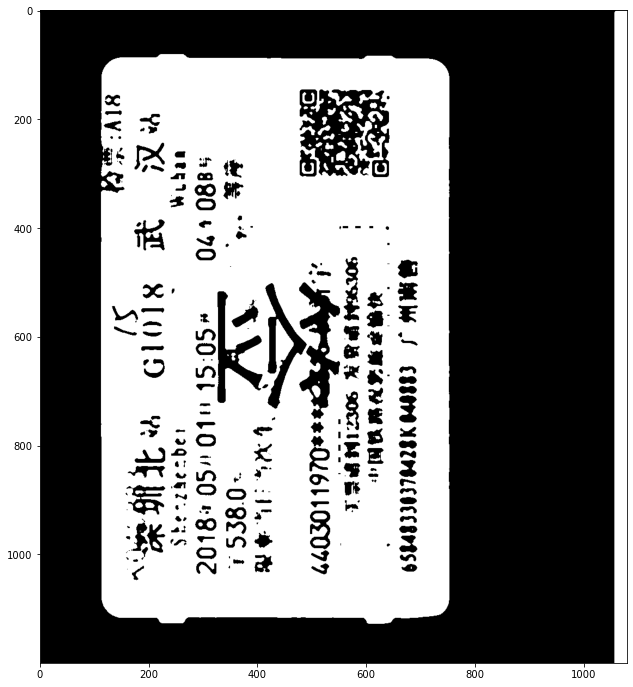

In [45]:
# 中值滤波：去除黑色背景中的盐噪声，只用来做边缘提取的效果很好，size取3,5,7均可
img_blur = cv2.medianBlur(img, 7)
# OTSU阈值 二值化
value_blur_otsu, img_blur_Otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU)
print(value_blur_otsu)
plt.figure(figsize = (12, 12))
plt.imshow(img_blur_Otsu, cmap = 'gray')
plt.show()
# cv2.imwrite('1.bmp', img_Otsu)

## 寻找矩形位置并分割

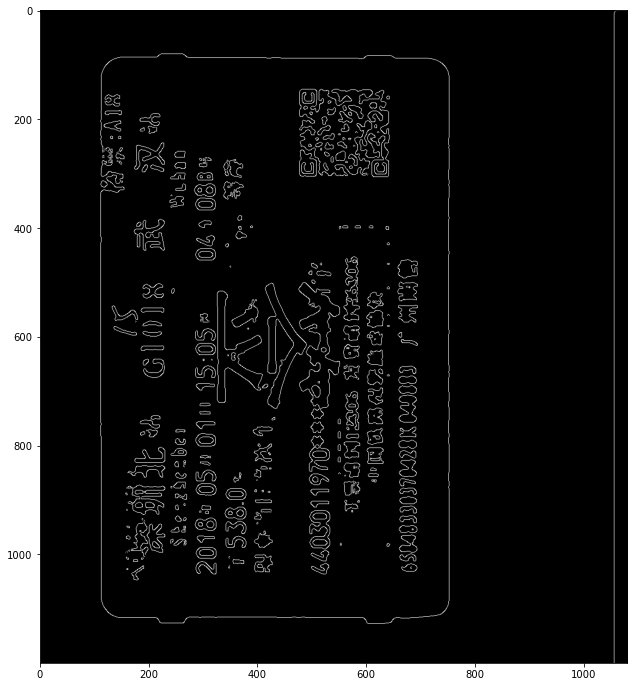

In [46]:
#利用Canny算子检测图像的边缘
edges = cv2.Canny(img_blur_Otsu, 50, 150, apertureSize = 3)
plt.figure(figsize = (12, 12))
plt.imshow(edges, cmap = 'gray')
plt.show()

轮廓数量 349


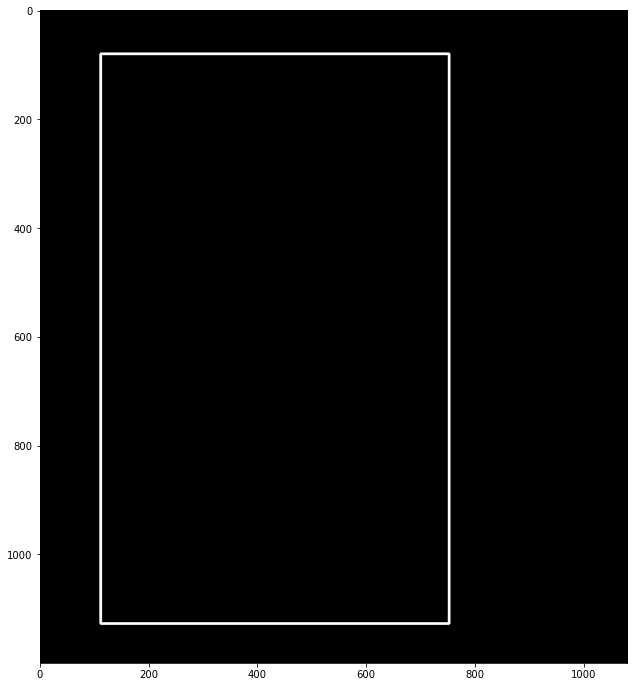

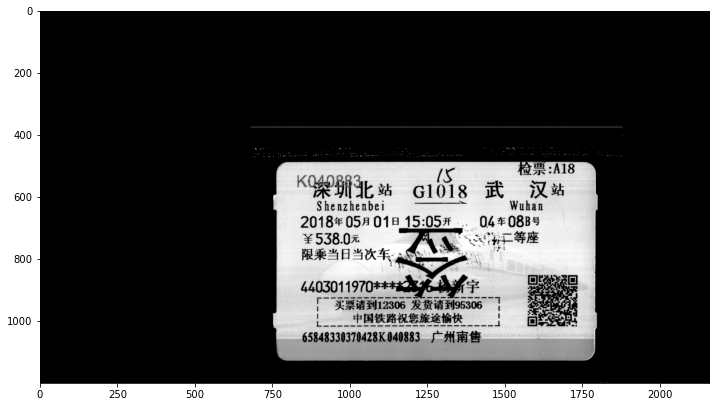

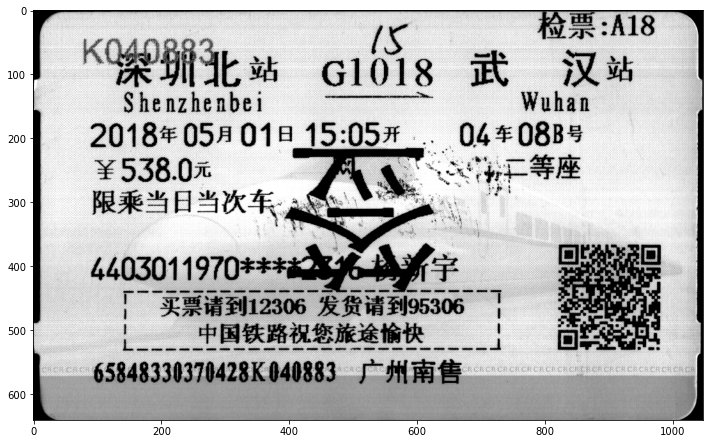

In [47]:
img_con = np.zeros(img.shape, dtype = np.int8)
img_cont = np.zeros(img.shape, dtype = np.int8)
# 获取轮廓
(contours, _) = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("轮廓数量", len(contours))

for i, c in enumerate(contours):  #遍历轮廓
    rect = cv2.minAreaRect(c)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
    box = np.int0(cv2.boxPoints(rect))  # 获取最小外接矩形的 4个顶点坐标
    
    # 根据面积过滤不需要的矩形（估计车票为700x1000）
    area = cv2.contourArea(box)
    if area < 400000: continue
    if area > 1000000: continue
    cv2.drawContours(img_con, [box], 0, (255, 0, 255), 3)
    
    
    rect_w, rect_h = int(rect[1][0]) + 1, int(rect[1][1]) + 1  # 最小外接矩形的宽和高        
    angle = rect[2]  #获取矩形相对于水平面的角度
    #以矩形的右下角为旋转中心
    if (rect_w > rect_h):
        x0, y0 = int(box[0][0]), int(box[0][1])
        M = cv2.getRotationMatrix2D((x0, y0), angle, 1)
    else:        
        t = rect_h
        rect_h = rect_w
        rect_w = t
        x0, y0 = int(box[3][0]), int(box[3][1])
        M = cv2.getRotationMatrix2D((x0, y0), angle - 90, 1)
    
    img_ro = cv2.warpAffine(img, M, (img.shape[1] * 2, img.shape[0]))
    img_seg = img_ro[(y0 - rect_h) : y0, x0 : (x0 + rect_w)]
    break #实验中发现车票对应的矩形轮廓可能会重复出现
        

plt.figure(figsize = (12, 12))
plt.imshow(img_con, cmap = 'gray')
plt.show()
plt.figure(figsize = (12, 12))
plt.imshow(img_ro, cmap = 'gray')
plt.show()
plt.figure(figsize = (12, 12))
plt.imshow(img_seg, cmap = 'gray')
plt.show()

## 分割后的车票倒立校正

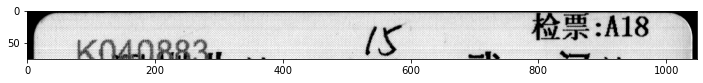

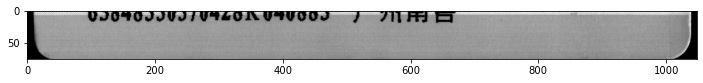

In [48]:
plt.figure(figsize = (12, 12))
plt.imshow(img_seg[0:75, 0:rect_w], cmap = 'gray')
plt.show()
plt.figure(figsize = (12, 12))
plt.imshow(img_seg[rect_h-75:rect_h,0:rect_w], cmap = 'gray')
plt.show()


193.1187786259542 143.51244274809162


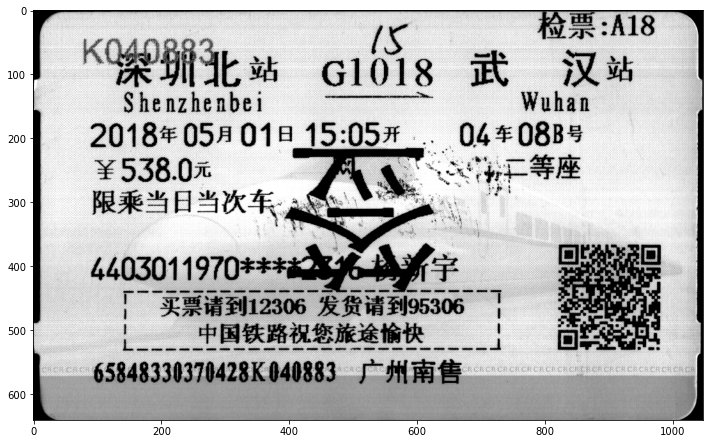

In [49]:
avg1 = np.average(img_seg[0:75, 0:rect_w])
avg2 = np.average(img_seg[rect_h-75:rect_h,0:rect_w])
print(avg1, avg2)
img_fix = np.copy(img_seg)
if (avg1 < avg2):
    M = cv2.getRotationMatrix2D((rect_w / 2, rect_h / 2), 180, 1)
    img_fix = cv2.warpAffine(img_seg, M, (rect_w, rect_h))

plt.figure(figsize = (12, 12))
plt.imshow(img_fix, cmap = 'gray')
plt.show()

# 车票序列号定位与分割

## 处理21位序列号
### 找到序列号大略区域

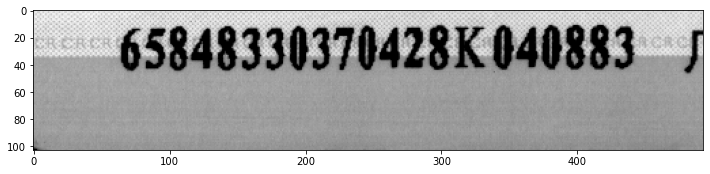

In [50]:
# 通过观察，获得大略区域，box表示左上和右下顶点坐标
box_21 = np.array([int(rect_h*0.84), int(rect_w * 0.03), rect_h, int(rect_w * 0.5)]).reshape(2, 2)
img_21 = img_fix[box_21[0,0]:box_21[1,0], box_21[0,1]:box_21[1,1]]

plt.figure(figsize = (12, 12))
plt.imshow(img_21, cmap = 'gray')
plt.show()

### 获得精确区域

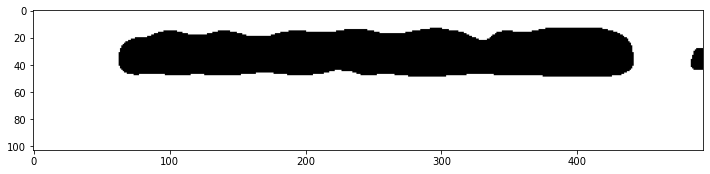

In [51]:
# 均值模糊（增加了序列号的连通度，理想状态下能够直接连通成一个区域）

img_21 = cv2.blur(img_21, (19, 19), 0)
img_21 = cv2.blur(img_21, (19, 19))
#二值化
_,img_21 = cv2.threshold(img_21, 0, 255, cv2.THRESH_OTSU)

# 多次开运算去除序列号之间的“桥”，连通为一个区域
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 9))
rectangle = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 9))
img_21_open = cv2.morphologyEx(img_21, cv2.MORPH_OPEN, ellipse)
img_21_open = cv2.morphologyEx(img_21_open, cv2.MORPH_OPEN, rectangle)

plt.figure(figsize = (12, 12))
plt.imshow(img_21_open, cmap = 'gray')
plt.show()


[[ 94 586]
 [ 94 551]
 [472 551]
 [472 586]]


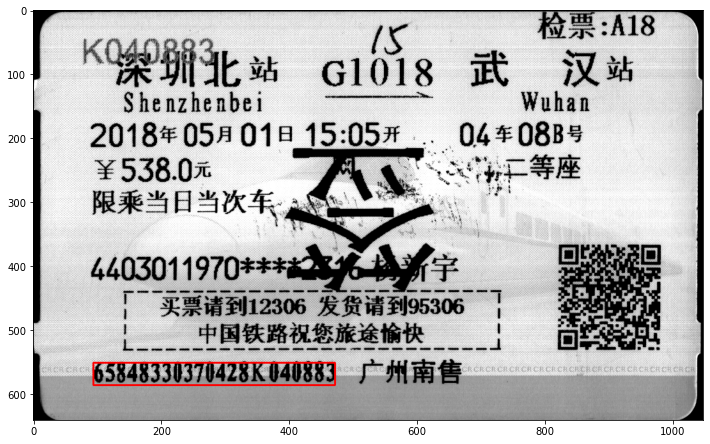

In [52]:
img_cont = cv2.cvtColor(np.copy(img_fix), cv2.COLOR_GRAY2RGB)
# 获取轮廓
(contours, _) = cv2.findContours(~img_21_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
c_max = contours[0]
area_max = cv2.contourArea(c_max)
for i, c in enumerate(contours):  #遍历轮廓
    # 找到面积最大的连通区域
    area = cv2.contourArea(c)
    if area_max < area:
        area_max = area
        c_max = c
rect_21_max = cv2.minAreaRect(c_max)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
box_21_max = np.int0(cv2.boxPoints(rect_21_max))  # 获取最小外接矩形的 4个顶点坐标
box_21_max[:,0] += box_21[0,1]
box_21_max[:,1] += box_21[0,0]    
cv2.drawContours(img_cont, [box_21_max], 0, (255, 0, 0), 2)
print(box_21_max)

plt.figure(figsize = (12, 12))
plt.imshow(img_cont)
plt.show()

### 定长分割序列号

17.46


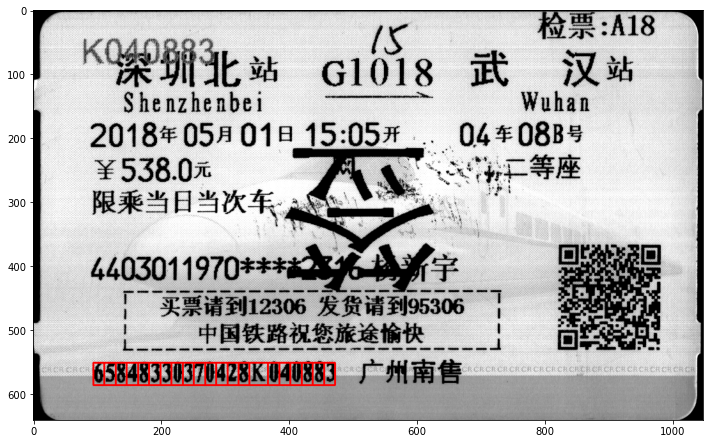

In [53]:
img_con = cv2.cvtColor(np.copy(img_fix), cv2.COLOR_GRAY2RGB)

x_min = np.min(box_21_max[:,0]) 
x_max = np.max(box_21_max[:,0]) 
y_min = np.min(box_21_max[:,1])
y_max = np.max(box_21_max[:,1])
#字母的宽度略大于数字的宽度，估计数字的宽度
step_x = (x_max - x_min) / 21 * 0.97
print(step_x)

img_cont = np.copy(img_fix)
x_1 = x_min
for i in range(1, 15):
    x_2 = x_min + round(step_x * i)
    box = np.array([[x_1, y_max],[x_1, y_min],[x_2, y_min],[x_2,y_max]])
    cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
    x_1 = x_2

x_4 = x_max
for i in range(1, 7):
    x_3 = x_max - round(step_x * i)
    box = np.array([[x_3, y_max],[x_3, y_min],[x_4, y_min],[x_4,y_max]])
    cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
    x_4 = x_3

box = np.array([[x_2, y_max],[x_2, y_min],[x_3, y_min],[x_3,y_max]])
cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)

plt.figure(figsize = (12, 12))
plt.imshow(img_con[:,:,::-1])
plt.show()

In [54]:
cv2.imwrite("1.jpg", img_con)

True

## 处理7位序列号
### 找到大略区域

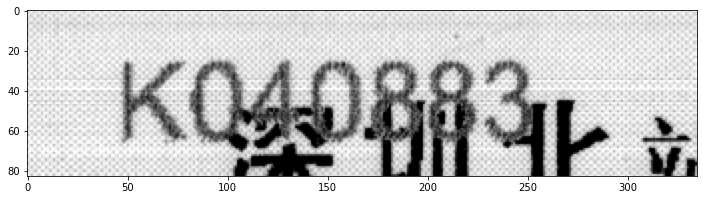

In [55]:
# 通过观察，获得大略区域，box表示左上和右下顶点坐标
box_7 = np.array([int(rect_h * 0.03), int(rect_w * 0.03), int(rect_h *0.16), int(rect_w * 0.35)]).reshape(2, 2)
img_7 = img_fix[box_7[0,0]:box_7[1,0], box_7[0,1]:box_7[1,1]]

plt.figure(figsize = (12, 12))
plt.imshow(img_7, cmap = 'gray')
plt.show()

### 找到精确位置

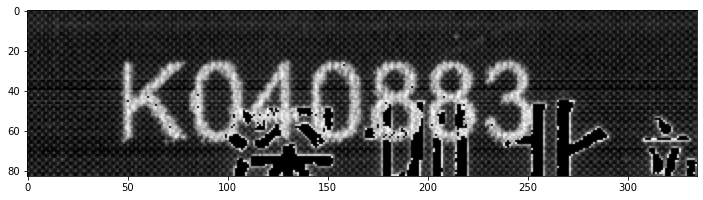

In [56]:
# 观察到序列号的灰度值范围为80~100，大于文字灰度值0~30
_, img_7_bi = cv2.threshold(~img_7, 225, 0, cv2.THRESH_TOZERO_INV)

plt.figure(figsize = (12, 12))
plt.imshow(img_7_bi, cmap = 'gray')
plt.show()

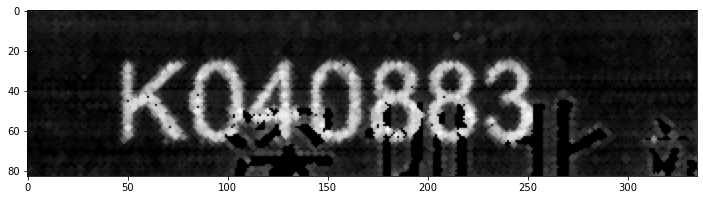

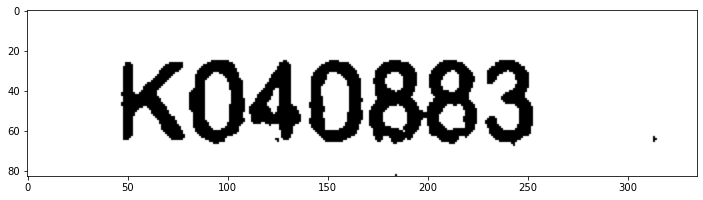

In [60]:
# 开运算处理文字的边缘
ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
rectangle = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
img_7_open = cv2.morphologyEx(img_7_bi, cv2.MORPH_OPEN, ellipse)
#img_7_open = cv2.morphologyEx(img_7_open, cv2.MORPH_OPEN, rectangle)
img_7_gau = cv2.GaussianBlur(img_7_open, (5, 5), 0)
_, img_7_open_ostu = cv2.threshold(img_7_gau, 0, 255, cv2.THRESH_OTSU)
img_7_con = cv2.morphologyEx(~img_7_open_ostu, cv2.MORPH_OPEN, rectangle)

plt.figure(figsize = (12, 12))
plt.imshow(img_7_open, cmap = 'gray')
plt.show()

plt.figure(figsize = (12, 12))
plt.imshow(~img_7_open_ostu, cmap = 'gray')
plt.show()

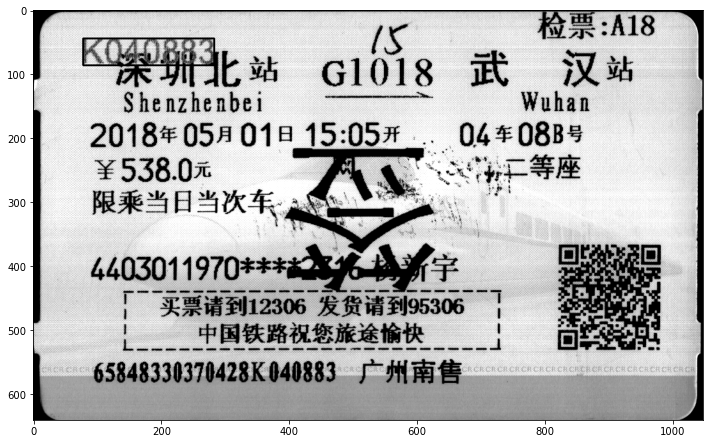

In [58]:
img_conto = np.copy(img_cont)
# 获取轮廓
(contours, _) = cv2.findContours(~img_7_con, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
c_max = contours[0]
area_max = cv2.contourArea(c_max)
for i, c in enumerate(contours):  #遍历轮廓
    # 找到面积最大的连通区域
    area = cv2.contourArea(c)
    if area_max < area:
        area_max = area
        c_max = c
rect_7_max = cv2.minAreaRect(c_max)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
box_7_max = np.int0(cv2.boxPoints(rect_7_max))  # 获取最小外接矩形的 4个顶点坐标
box_7_max[:,0] += box_7[0,1]
box_7_max[:,1] += box_7[0,0]
cv2.drawContours(img_conto, [box_7_max], 0, (0, 0, 255), 2)

plt.figure(figsize = (12, 12))
plt.imshow(img_conto, cmap = 'gray')
plt.show()

### 灰度值分割字符

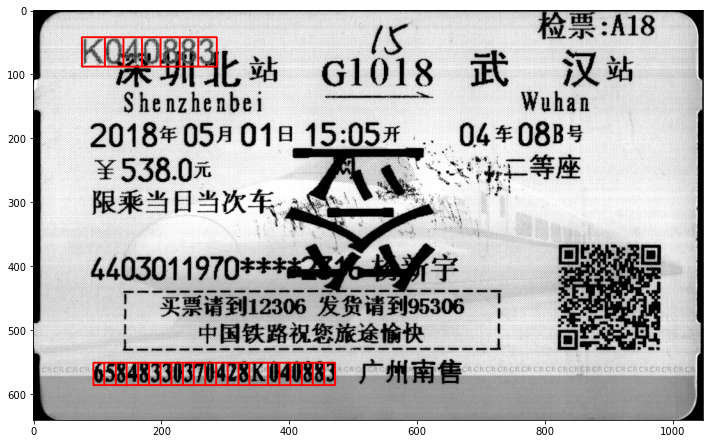

In [59]:
img_conto = np.copy(img_con)
x_min = np.min(box_7_max[:,0]) - 2
x_max = np.max(box_7_max[:,0]) + 2
y_min = np.min(box_7_max[:,1])
y_max = np.max(box_7_max[:,1])

x_min = np.min(box_7_max[:,0]) - 2
x_max = np.max(box_7_max[:,0]) + 4
y_min = np.min(box_7_max[:,1]) - 2
y_max = np.max(box_7_max[:,1]) + 2

# 防止未完全连通的情况
if (x_max - x_min < 250):
    num = round((x_max - x_min) / 29)
    step_x = (x_max - x_min) / num + 1
    if (x_min > 100): x_min = x_max - int(step_x * 7)
    elif (x_max < 250): x_max = x_min + int(step_x * 7)

#估计数字的宽度
step_x = (x_max - x_min) / 7
    
#利用灰度值找到第一个数字的起始位置
_, img_otsu = cv2.threshold(img_fix, 0, 255, cv2.THRESH_OTSU) 
x_1 = x_max - int(step_x * 6) - 5
while(np.min(img_otsu[y_min:y_max,x_1]) < 100):
    x_1 += 1
x_2 = x_1
while(np.min(img_otsu[y_min:y_max,x_2]) >= 100):
    x_2 += 1

gap = x_2 - x_1
step_x_new = (x_max - x_2) / 6 + gap / 16 
if (step_x_new > (x_max - x_min) / 8):
    step_x = step_x_new

x_4 = x_max
for i in range(1, 7):
    x_3 = x_max - round(step_x * i)
    box = np.array([[x_3, y_max],[x_3, y_min],[x_4, y_min],[x_4,y_max]])
    cv2.drawContours(img_conto, [box], 0, (0, 0, 255), 2)
    x_4 = x_3

box_ = np.array([[x_min, y_max],[x_min, y_min],[x_3, y_min],[x_3,y_max]])
cv2.drawContours(img_conto, [box_], 0, (0, 0, 255), 2)


plt.figure(figsize = (12, 12))
plt.imshow(img_conto[:,:,::-1])
plt.show()